In this notebook:
    - correlated gauges without predictions (y) to gauges that do have predictions (features)
    - use KNN based on lat, long, alt, basin to determine 5-10 closest gages to those that we are looking for
    - result should be a dataframe with first column as the y USGS gage and each additional column a feature USGS gage that has a NOAA prediction OR a dictionary with each key pointing to the ten closest gages
    - set threshold for how close a gage would need to be to be considered

In [75]:
import pandas as pd
from bs4 import BeautifulSoup
import os
import requests
import time
import re

In [76]:
import pickle
path="C:\Springboard\Github\gauge_info"
os.chdir(path)

In [77]:
# loade the dataframe of potential features that have NOAA predictions
df = pickle.load(open("USGS_features.pkl", "rb"))
df

,NOAA_gauge,River,State,Elevation,Segment,USGS_link,usgs,lat,long,alt,basin
0,SPRA3,San Pedro,AZ,2820.0,7,http://waterdata.usgs.gov/az/nwis/uv?09472050,09472050,32.446183,110.488418,2820.00,Lower San Pedro
5,AFHA3,Agua Fria,AZ,4400.0,17,http://waterdata.usgs.gov/az/nwis/uv?09512450,09512450,34.485278,112.237500,4400.00,Agua Fria
6,AFMA3,Agua Fria,AZ,3434.0,18,http://waterdata.usgs.gov/az/nwis/uv?09512500,09512500,34.315307,112.064046,3434.00,Agua Fria
7,AFRA3,Agua Fria,AZ,1800.0,19,http://waterdata.usgs.gov/az/nwis/uv?09512800,09512800,34.015589,112.167938,1800.00,Agua Fria
10,ATPA3,Altar Wash,AZ,2975.0,24,http://waterdata.usgs.gov/az/nwis/uv?09486800,09486800,31.838972,111.404269,2975.15,Brawley Wash
...,...,...,...,...,...,...,...,...,...,...,...
450,YASC2,Yampa,CO,7240.0,2,http://waterdata.usgs.gov/co/nwis/uv?09237450,09237450,40.264261,106.891767,7240.00,Upper Yampa
451,YDLC2,Yampa,CO,5600.0,17,http://waterdata.usgs.gov/co/nwis/uv?09260050,09260050,40.451634,108.525101,5600.00,Lower Yampa
452,YMSC2,Yampa,CO,7050.0,4,http://waterdata.usgs.gov/co/nwis/uv?09237500,09237500,40.286544,106.829056,7050.00,Upper Yampa
453,YLLU1,Yellowstone,UT,7430.0,20,http://waterdata.usgs.gov/ut/nwis/uv?09292500,09292500,40.511893,110.341549,7430.00,Duchesne


In [78]:
# load the dataframe of target gages that we want to model
dt = pickle.load(open("USGS_targets.pkl", "rb"))
dt

,USGS,lat,long,alt,basin
0,10140700,41.231819,111.984497,4285.00,Lower Weber
1,10149000,40.118012,111.314622,6320.00,Spanish Fork
2,10155200,40.554398,111.433243,5691.59,Provo
3,10224000,39.481898,112.393834,4660.00,Lower Sevier
4,10308200,38.714627,119.764899,5400.00,Upper Carson
...,...,...,...,...,...
147,06892350,38.983337,94.964689,753.87,"Lower Kansas, Kansas"
148,07169800,37.375597,96.185548,897.30,Elk
149,06775900,41.778611,100.525278,2798.18,Dismal
150,06461500,42.902222,100.362222,2287.57,Middle Niobrara


One thing we didn't look at in the previous notebook: number of basins that are possible. If we are going to create dummy variables for thie, then we need to know how many dummies. Let's find this value for each DF.

In [79]:
dt['basin'].value_counts()

Upper Rio Grande      7
Upper North Platte    4
Animas                4
Roaring Fork          4
Snake Headwaters      3
                     ..
North Fork Payette    1
Spanish Fork          1
Palisades             1
Upper Tongue          1
Lower Henrys          1
Name: basin, Length: 84, dtype: int64

In [80]:
df['basin'].value_counts()

Colorado Headwaters            13
Upper Virgin                   11
Duchesne                       10
Upper Yampa                     9
Upper Weber                     9
                               ..
Lower Colorado                  1
Havasu-Mohave Lakes             1
Lower Lake Powell               1
Tonto                           1
Big Chino-Williamson Valley     1
Name: basin, Length: 121, dtype: int64

So we have 84 basins in the targets list and 121 basins in the features dataframe. We'll probbably have to make dummy variables for these. We may want to consider throwing out gages from the targets if there is not a NOAA gage within that same drainage basin. Let's plot those locations out.

In [81]:
# to make life easier, let's create a column that is consistent with google format (West is negagtive)
df['lng']= -1*df['long']
dt['lng']= -1*dt['long']

In [82]:
# let's just plot them on a normal graph without the map
import matplotlib.pyplot as plt
import numpy as np

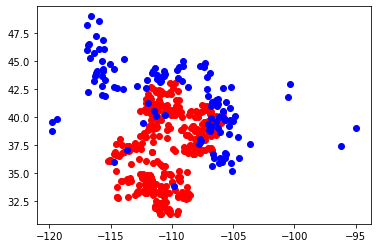

In [83]:
plt.scatter(df['lng'],df['lat'], c='red')
plt.scatter(dt['lng'],dt['lat'], c='blue')
plt.show()

That is very cool to see how some of the gages are way outside of where we could potentially predict. I think we could just prune these by eliminating the drainage basin. I think it would be cool to see these on a map first.

In [84]:
# initialize the map
import folium
m = folium.Map(location=[37.625500, -111.439472], zoom_start=5)

In [85]:
# add all of the markers from the FEATURE dataframe - in RED
for i, r in df.iterrows():
    folium.Marker(location=[r['lat'], r['lng']], popup=r['basin'], icon=folium.Icon(color='red')).add_to(m)
# add all of the markers from the TARGET dataframe - in BLUE
for i, r in dt.iterrows():
    folium.Marker(location=[r['lat'], r['lng']], popup=r['basin'], icon=folium.Icon(color='blue')).add_to(m)
m

We can see that a lot of the target that we hope to predict for are WAY outside of the area covered by the NOAA predictions, so we need to find a way to drop some of these. I think that best way to do that is to drop the target gages that are not in the same river basin as the features gages. <br>



In [86]:
m.save('all_features.html')

In [87]:
target_basins = set(dt['basin'])
feature_basins = set(df['basin'])
good_basins = target_basins.intersection(feature_basins)
len(good_basins)

11

That is way less than I was hoping for; let's see the river basins that are included in that list

In [88]:
good_basins

{'Animas',
 'Colorado Headwaters',
 'Eagle',
 'East-Taylor',
 'Havasu-Mohave Lakes',
 'Lower Virgin',
 'Lower Weber',
 'Provo',
 'Roaring Fork',
 'Spanish Fork',
 'Uncompahgre'}

In [89]:
# let's reduce down to just those target basins in the TARGET dataframe
dt1 = dt[dt['basin'].isin(good_basins)]
dt1

,USGS,lat,long,alt,basin,lng
0,10140700,41.231819,111.984497,4285.00,Lower Weber,-111.984497
1,10149000,40.118012,111.314622,6320.00,Spanish Fork,-111.314622
2,10155200,40.554398,111.433243,5691.59,Provo,-111.433243
79,09064600,39.553875,106.402529,8078.37,Eagle,-106.402529
84,09081000,39.373317,107.083937,6470.00,Roaring Fork,-107.083937
85,09073300,39.141100,106.774204,8120.00,Roaring Fork,-106.774204
86,09075400,39.193833,106.833667,7882.00,Roaring Fork,-106.833667
87,09033300,40.006892,105.848272,8274.00,Colorado Headwaters,-105.848272
88,09359010,37.802774,107.672839,9245.98,Animas,-107.672839
92,09358000,37.811108,107.659228,9290.00,Animas,-107.659228


In [90]:
dt1.shape

(20, 6)

That cut down our data set a lot more, but I think we are covered a lot better for making these predictions. Let's map it to see where we are again.

In [91]:
m = folium.Map(location=[37.625500, -111.439472], zoom_start=5)
for i, r in df.iterrows():
    folium.Marker(location=[r['lat'], r['lng']], popup=r['basin'], icon=folium.Icon(color='red')).add_to(m)
# add all of the markers from the TARGET dataframe - in BLUE
for i, r in dt1.iterrows():
    folium.Marker(location=[r['lat'], r['lng']], popup=r['basin'], icon=folium.Icon(color='blue')).add_to(m)
m

These all look so much better. Just to check on things, let's also map the target gages that we dropped

In [92]:
m.save('reduced_targets.html')

In [93]:
dt_drop = dt[~dt['basin'].isin(good_basins)]

In [94]:
m = folium.Map(location=[37.625500, -111.439472], zoom_start=5)
for i, r in df.iterrows():
    folium.Marker(location=[r['lat'], r['lng']], popup=r['basin'], icon=folium.Icon(color='red')).add_to(m)
# add all of the markers from the TARGET dataframe - in BLUE
for i, r in dt_drop.iterrows():
    folium.Marker(location=[r['lat'], r['lng']], popup=r['basin'], icon=folium.Icon(color='blue')).add_to(m)
m

There are a few target basins that are close to or contained within the area of the features basins, but this looks like a great place to start - there are not tons of target gages that we just threw out. <br>
We can come back to these gages later, but we'll have to pull data from a different river basin forecast center and parse it in a different manner.

Let's use Eucleadean Distance to find the best feature gages to pull data for. It's actually more like the inverse of KNN: we are looking for the K number of feature points that are closest to the target point. Those feature points will then be used to build a model for that target point. For practice, I will write this myself.

In [98]:
m.save('remaining_targets.html')

In [95]:
# may want to calculate normalize the eucleadean distance first (based on min - max)
lat_norm = max([max(dt1['lat']), max(df['lat'])]) - min([min(dt1['lat']), min(df['lat'])])
lat_norm

11.68378336

In [96]:
lng_norm = max([max(dt1['lng']), max(df['lng'])]) - min([min(dt1['lng']), min(df['lng'])])
lng_norm

9.431103300000004

In [97]:
alt_norm = max([max(dt1['alt']), max(df['alt'])]) - min([min(dt1['alt']), min(df['alt'])])
alt_norm

9705.0

Good to get this normalizing done; these factors can be used below to help normalize the distances. There seems to be an issue if we consider using the river basin in this calculation: that component would dominate the calculation of the distance and some of the differences between basins are not that significant. We are going to do the calculation by throwing out the basin and hope we still have good results.

In [99]:
# add the features column to the targets dataframes
dt1['feat_USGS'] = 0
dt1['feat_NOAA'] = 0

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
d = {10: 10000, 11:1000, 12:100, 13: 200, 14: 250, 15: 300, 16: 350, 17: 400, 18: 450, 19: 500}
print(list(d.keys()))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [101]:
# for gage in targets
for i, t in dt1.iterrows():
    # create a dictionary that contains the top 5 gages and their scores
    d = {10: 10000, 11:1000, 12:100, 13: 200, 14: 250, 15: 300, 16: 350, 17: 400, 18: 450, 19: 500}
    # for gage in features
    for j, f in df.iterrows():
        # calculate eucleadean distance - normalize the distance in the calculation
        lat_dist = ((t['lat']-f['lat'])/lat_norm)**2
        lng_dist = ((t['lng']-f['lng'])/lng_norm)**2
        alt_dist = ((t['alt']-f['alt'])/alt_norm)**2
        dist = lat_dist + lng_dist + alt_dist
        # if distance is in the 10 smallest, add the gage and the distance to the dictionary
        if dist < max(d.values()):
            # add the gauge and distance to the dictionary
            d[f['usgs']] = dist
            # remove the largest value from the dictionary
            key_to_delete = max(d, key=d.get)
            del d[key_to_delete]
    # dictionary keys (gages) are added to target dataframe as features
    dt1['feat_USGS'][i] = list(d.keys())
    # may also want to add the corresponding NOAA code (maybe add these as a tuple)   
    

C:\Users\sjrek\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sjrek\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\sjrek\anaconda3\lib\site-packages\pandas\core\series.py:1024: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[key] = value
C:\Users\sjrek\anaconda3\l

In [102]:
dt1

,USGS,lat,long,alt,basin,lng,feat_USGS,feat_NOAA
0,10140700,41.231819,111.984497,4285.00,Lower Weber,-111.984497,"[10126000, 10092700, 10010000, 10171000, 10105...",0
1,10149000,40.118012,111.314622,6320.00,Spanish Fork,-111.314622,"[10164500, 10133800, 10133650, 10133600, 09313...",0
2,10155200,40.554398,111.433243,5691.59,Provo,-111.433243,"[10164500, 10131000, 10134500, 10132500, 10155...",0
79,09064600,39.553875,106.402529,8078.37,Eagle,-106.402529,"[09057500, 09034250, 09034500, 09065100, 09063...",0
84,09081000,39.373317,107.083937,6470.00,Roaring Fork,-107.083937,"[09132095, 09070500, 09085100, 09081600, 09070...",0
85,09073300,39.141100,106.774204,8120.00,Roaring Fork,-106.774204,"[09065100, 09112500, 09078600, 09080400, 09066...",0
86,09075400,39.193833,106.833667,7882.00,Roaring Fork,-106.833667,"[09065100, 09112500, 09078600, 09080400, 09066...",0
87,09033300,40.006892,105.848272,8274.00,Colorado Headwaters,-105.848272,"[09050700, 09010500, 09034250, 09019500, 09034...",0
88,09359010,37.802774,107.672839,9245.98,Animas,-107.672839,"[09126000, 09118450, 09165000, 09074000, 09365...",0
92,09358000,37.811108,107.659228,9290.00,Animas,-107.659228,"[09126000, 09118450, 09165000, 09074000, 09365...",0


This is exactly what I want. Let's look at one of those on a map.

In [103]:
dt1['feat_USGS'][0]

['10126000',
 '10092700',
 '10010000',
 '10171000',
 '10105900',
 '10168000',
 '10109000',
 '10140100',
 '10136500',
 '10141000']

In [104]:
# plot the first target gage
m = folium.Map(location=[dt1['lat'][0], dt1['lng'][0]], zoom_start=8)
# map the first marker
folium.Marker(location=[dt1['lat'][0], dt1['lng'][0]], popup=dt1['basin'][0], icon=folium.Icon(color='red')).add_to(m)
# plot the corresponding feature gages
for n in dt1['feat_USGS'][0]:
    folium.Marker(location=[df[df['usgs'] == n]['lat'], df[df['usgs'] == n]['lng']], popup=df[df['usgs'] == n]['basin'], icon=folium.Icon(color='blue')).add_to(m)
m

In the future, I may want to abstract this to a function that could take in the dataframes of targest and features with columns names to use for the Eucleadean Distance (list of column names). Column names would need to be the same in each DataFrame.

In [105]:
m.save('weber.html')

In the next notebook:
    - pull USGS data for length that each gage is in operation
    - potentially cut time scale of data based on when the flow has never been above a certain threshold
    - each of the 125 gages should have a dataframe (list of dataframes)

In the notebook after that:
    - build 125 models (using Lasso Regression, we believe)
    - set threshold for accuracy in predicting flow
    - throw out models that do not meet that accuracy
    - throw out features in models that are no longer needed
    - do other prep for putting models into production (test in real time and have accuracy feedback)